# Introduction: Downloading Wikipedia Articles

In this notebook, we will download all of the latest wikipedia articles. After getting the data, we'll work on making sense of it using data science!

In [1]:
import requests
from bs4 import BeautifulSoup
import os
# import time
# from keras.utils import get_file
# try:
#     from urllib.request import urlretrieve
# except ImportError:
#     from urllib import urlretrieve
# import xml.sax

# import subprocess
# import mwparserfromhell
# import json

## Searching through Wikipedia Dump

To start, we make a request to the wikimedia dump of Wikipedia. We'll search through `enwiki` which has the English language dumps of wikipedia. This first request finds the available recent dumps and lists them.

In [2]:
base_url = 'https://dumps.wikimedia.org/enwiki/'
index = requests.get(base_url).text
soup_index = BeautifulSoup(index, 'html.parser')

# Find the links that are dates of dumps
dumps = [a['href'] for a in soup_index.find_all('a') if 
         a.has_attr('href')]
dumps

['../',
 '20180601/',
 '20180620/',
 '20180701/',
 '20180720/',
 '20180801/',
 '20180820/',
 '20180901/',
 'latest/']

The next line of code finds the html of the dump for the first of September.

In [3]:
dump_url = base_url + '20180901/'

# Retrieve the html
dump_html = requests.get(dump_url).text

Now we can parse through the html text to find the available files for download. We will focus only on the most recent revision of the articles themselves. It is possible to get the past history of articles, the edits, the discussion, and metadata, but the articles themselves provide us with more than enough data! 

For more information on the available downloads, take a look at the [Wikimedia dump](https://dumps.wikimedia.org/) or on [Wikipedia itself](https://en.wikipedia.org/wiki/Wikipedia:Database_download#English-language_Wikipedia).

The most recent revision of every single article (what we are after) is available in a single file as `pages-articles.xml.bz2`. However, we'll download the articles in smaller chunks so that we can then process it in parallel (rather than all sequentially). The single file - which is compressed XML (using bz) - is over 15 GB. 

To find all the individual files, we'll search through the html from the dump identified earlier. We'll look for any files that have `pages_articles` in the text. To parse through html (or other markup languages), we can use Beautiful Soup. If you are doing any web scraping, this will be a very useful library to learn! 

In [4]:
# Convert to a soup
soup_dump = BeautifulSoup(dump_html, 'html.parser')
soup_dump.find_all('li', {'class': 'file'}, limit = 10)[0]

<li class="file"><a href="/enwiki/20180901/enwiki-20180901-pages-articles-multistream.xml.bz2">enwiki-20180901-pages-articles-multistream.xml.bz2</a> 15.2 GB</li>

In [5]:
files = []

# Search through all files
for file in soup_dump.find_all('li', {'class': 'file'}):
    text = file.text
    # Select the relevant files
    if 'pages-articles' in text:
        files.append((text.split()[0], text.split()[1:]))
        
files[:10]

[('enwiki-20180901-pages-articles-multistream.xml.bz2', ['15.2', 'GB']),
 ('enwiki-20180901-pages-articles-multistream-index.txt.bz2', ['195.6', 'MB']),
 ('enwiki-20180901-pages-articles.xml.bz2', ['14.3', 'GB']),
 ('enwiki-20180901-pages-articles1.xml-p10p30302.bz2', ['165.3', 'MB']),
 ('enwiki-20180901-pages-articles2.xml-p30304p88444.bz2', ['195.8', 'MB']),
 ('enwiki-20180901-pages-articles3.xml-p88445p200507.bz2', ['251.7', 'MB']),
 ('enwiki-20180901-pages-articles4.xml-p200511p352689.bz2', ['257.3', 'MB']),
 ('enwiki-20180901-pages-articles5.xml-p352690p565312.bz2', ['281.7', 'MB']),
 ('enwiki-20180901-pages-articles6.xml-p565314p892912.bz2', ['303.9', 'MB']),
 ('enwiki-20180901-pages-articles7.xml-p892914p1268691.bz2', ['311.4', 'MB'])]

We only want the partitioned files (each of which has tens or hundreds of thousands of articles), so we can further our selection.

In [6]:
files_to_download = [file[0] for file in files if '.xml-p' in file[0]]
files_to_download[-10:]

['enwiki-20180901-pages-articles27.xml-p44163464p45663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p45663464p47163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p47163464p48663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p48663464p50163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p50163464p51663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p51663464p53163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p53163464p54663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p54663464p56163464.bz2',
 'enwiki-20180901-pages-articles27.xml-p56163464p57663464.bz2',
 'enwiki-20180901-pages-articles27.xml-p57663464p58360959.bz2']

## Download Data

Now we need to actually download the data. This can be done using the keras `get_file` utility which downloads the specified file at the specified url. If we already have the entire dataset downloaded, then we don't want to download it again! For that reason we first use a check to see if the data exists.

The default download directory for keras is `~/.keras/datasets`.

In [7]:
import sys
from keras.utils import get_file

keras_home = '/home/ubuntu/.keras/datasets/'

Using TensorFlow backend.


In [9]:
data_paths = []
file_info = []

# Iterate through each file
for file in files_to_download:
    path = keras_home + file
    
    # Check to see if the path exists
    if not os.path.exists(keras_home + file):
        print('Downloading')
        # If not, download the file
        data_paths.append(get_file(file, dump_url))
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file, file_size, file_articles))
        
    # Otherwise extract information
    else:
        data_paths.append(path)
        # Find the file size in MB
        file_size = os.stat(path).st_size / 1e6
        
        # Find the number of articles
        file_articles = int(file.split('p')[-1].split('.')[-2]) - int(file.split('p')[-2])
        file_info.append((file.split('-')[-1], file_size, file_articles))

What is the largest file? We can use `sorted` to sort by the file size.

In [10]:
sorted(file_info, key = lambda x: x[1], reverse = True)[:5]

[('p6197599p7697599.bz2', 397.133836, 1500000),
 ('p3926864p5040435.bz2', 396.765417, 1113571),
 ('p5040438p6197593.bz2', 390.834855, 1157155),
 ('p3046517p3926861.bz2', 383.739076, 880344),
 ('p7744803p9244803.bz2', 374.264421, 1500000)]

How about the file with the most articles? Just change the key for sorting.

In [11]:
sorted(file_info, key = lambda x: x[2], reverse = True)[:5]

[('p6197599p7697599.bz2', 397.133836, 1500000),
 ('p7744803p9244803.bz2', 374.264421, 1500000),
 ('p9518059p11018059.bz2', 310.0126, 1500000),
 ('p11539268p13039268.bz2', 369.371949, 1500000),
 ('p13693075p15193075.bz2', 352.199415, 1500000)]

It looks like the largest files are about 400 MB compressed (bz2) and contain 150,000 articles. There should be a total of 58 million articles on English wikipedia.

How about putting this info into a dataframe?

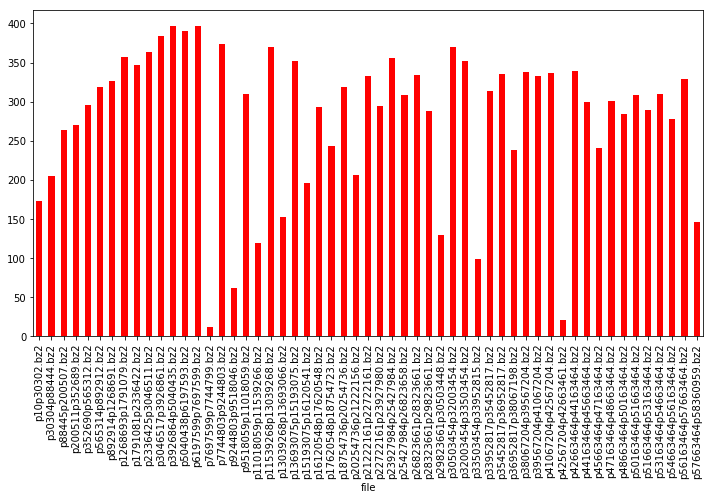

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
file_df = pd.DataFrame(file_info, columns = ['file', 'size (MB)', 'articles']).set_index('file')
file_df['size (MB)'].plot.bar(color = 'red', figsize = (12, 6));

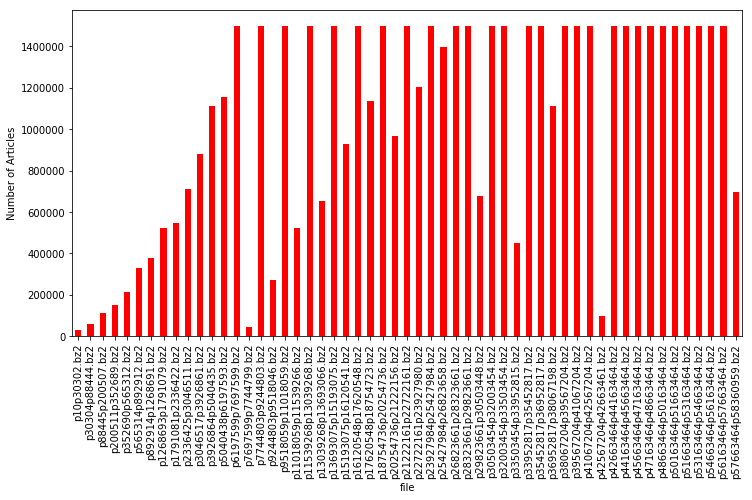

In [13]:
file_df['articles'].plot.bar(color = 'red', figsize = (12, 6));
plt.ylabel('Number of Articles');

It looks like the upper limit for number of articles is 150,000.

In [14]:
print(f"There are {file_df['articles'].sum()} total articles.")

There are 58360835 total articles.


There are a total of 58,360,835 articles, which represents all of English language Wikipedia on September 1!

In [16]:
print(f"The total size of files on disk is {file_df['size (MB)'].sum() / 1e3} GB")

The total size of files on disk is 15.398009268 GB


# Sorting Through the Data

Together, the files take up 15.4 GB. Decompressed as xml, it's close to 50 GB. We could decompress each file into XML and then parse through it, but we can also parse through the decompressed file one line at a time. If we are concered about disk space, this is a better option. Working through the compressed file one line at a time also might be the only option is cases where the individual files are too large to fit in memory. 

We'll start by working through one of the files and then develop functions that we can run on all of the files. Because we downloaded the data in chunks, we'll be able to parallelize the parsing operations using multiple threads on our machine.

To get started, make sure you have `bzcat` installed on your system. The [`bzcat` utility] (http://www.qnx.com/developers/docs/6.5.0SP1.update/com.qnx.doc.neutrino_utilities/b/bzcat.html) is a command line program that decompresses a bz2 compressed file and sends the contents to standard out. To go through the files one line at a time, we simply iterate over the command to decompress the file. We call the command using `subprocess` which is often used to execute system commands in Python.

Another option for decompressing the file is `bz2`. However, in tests (see below), I found this to be much slower than `bzcat`. 

In [17]:
import bz2
import subprocess

data_path = data_paths[15]
data_path

'/home/ubuntu/.keras/datasets/enwiki-20180901-pages-articles15.xml-p7744803p9244803.bz2'

In [18]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(bz2.BZ2File(data_path, 'r')):
    lines.append(line)
    if i > 1e6:
        break

5.08 s ± 55.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [19]:
%%timeit -n 3 -r 3

lines = []
for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 1e6:
        break

2.58 s ± 41.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


The `subprocess` + `bzcat` approach is nearly twice as fast. Let's run this again and see what kind of data we have.

In [20]:
lines = []

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    lines.append(line)
    if i > 5e5:
        break
        
lines[-165:-109]

[b'  <page>\n',
 b'    <title>Carroll Knicely</title>\n',
 b'    <ns>0</ns>\n',
 b'    <id>7772446</id>\n',
 b'    <revision>\n',
 b'      <id>850825914</id>\n',
 b'      <parentid>819310247</parentid>\n',
 b'      <timestamp>2018-07-18T05:43:30Z</timestamp>\n',
 b'      <contributor>\n',
 b'        <username>Ser Amantio di Nicolao</username>\n',
 b'        <id>753665</id>\n',
 b'      </contributor>\n',
 b'      <comment>/* External links */add authority control, test using [[Project:AWB|AWB]]</comment>\n',
 b'      <model>wikitext</model>\n',
 b'      <format>text/x-wiki</format>\n',
 b'      <text xml:space="preserve">\'\'\'Carroll F. Knicely\'\'\' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the \'\'[[Glasgow Daily Times]]\'\' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary.\n',

Here we have a complete article. We could go through each article and extract out the information, but that would be extremely inefficient. Instead, we can use an xml parser to extract precisely the information we want.

## Parsing Articles 

In order to get useful information from this data, we have to parse it on two levels.

1. Extract the titles and article text from the XML
2. Extract relevant information from the article text

To solve the first problem, we'll use tool purpose built for the task of parsing XML, SAX: The Simple API for XML. [The documentation](http://pyxml.sourceforge.net/topics/howto/section-SAX.html) is a little difficult to follow, but the basic idea is that we can use SAX to search through the XML and select elements based on the tag. (If you need an introduction to XML, I'd highly recommend starting [here](https://www.w3schools.com/xml/default.asp)).

For example, if we have the follow XML element, we want to extract the text that occurs between the `<title>` tags:

`<title>Carroll Knicely</title>`

Likewise, if we have the content of an article like below, we want to extract the text that occurs between the `<text>` tags. 

```XML
<text xml:space="preserve">\'\'\'Carroll F. Knicely\'\'\' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the \'\'[[Glasgow Daily Times]]\'\' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary.\n'
</text>
```

We'll use the SAX parser to do exactly that: find the titles and text content of the articles. Then, we can pass the text to another parser to extract information from the article. 

Explaining how SAX works is a little more difficult than just showing, so I'll present the code and show some examples.

In [21]:
import xml.sax

class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Parse through XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._pages = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            self._pages.append((self._values['title'], self._values['text']))

We need to create a `handler` object of the `WikiXMLHandler` class. Then we pass the handler in as the content handler to a SAX `parser`. Basically, we are overriding the default SAX parser in order to do what we want: find the titles and texts.

In [23]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

handler._pages

[]

Let's work through a single article. We `feed` in one line of XML at a time to the `parser`. It searches the XML for the tags using the methods in the handler. The correct data is then stored in the handler. 

In [24]:
for l in lines[-165:-109]:
    parser.feed(l)

In [25]:
handler._pages

[('Carroll Knicely',
  "'''Carroll F. Knicely''' (born c. 1929 in [[Staunton, Virginia]] - died November 2, 2006 in [[Glasgow, Kentucky]]) was [[Editing|editor]] and [[Publishing|publisher]] of the ''[[Glasgow Daily Times]]'' for nearly 20 years (and later, its owner) and served under three [[Governor of Kentucky|Kentucky Governors]] as commissioner and later Commerce Secretary. \n \n ==Career in publishing== \n Knicely started out as an [[apprentice]] [[Linotype machine|linotype]] operator at ''[[The News-Virginian]]''.  In 1957, he relocated to [[Glasgow, Kentucky]] as the president, editor and publisher of the ''Glasgow Daily Times''.  In 1963, Knicely and his wife Evely became the sole owners of the newspaper and of the Glasgow Publishing Corporation.  He also held interests in several newspapers all over [[Kentucky]] and was part owner of a weekly newspaper in [[Westmoreland, Tennessee]]. \n \n Knicely served as president of the Kentucky Press Association and president of the Kent

We have successfully extracted one page! Once we have the page text, we need to process it as well to find the information we want. We'll write that function next. First, let's see this process again, this time finding two different articles.

In [26]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._pages) > 2:
        break
        
print([x[0] for x in handler._pages])

['Zhou Wei Hui', 'Fred Jones (fictional character)', 'Sosnovski Raion']


The next step is to process an entire article. For this, we will turn to the `mwparserfromhell` library. [This library](https://github.com/earwig/mwparserfromhell) is custom made for parsing `MediaWiki` wikicode. This includes Wikipedia articles. [MediaWiki](https://www.mediawiki.org/wiki/MediaWiki) is used by Wikipedia and numerous other projects and provides a relatively standardized template for creating wiki pages. 

## Parsing Articles

The best way to figure out how to parse an article is simply to do it! Let's work through the article for `Zhou Wei Hui`. All we need to do is pass the Wikipedia article text to the `mwparserfromhell`. 

In [39]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._pages) > 50:
        break

In [55]:
import mwparserfromhell 

print(handler._pages[6][0])
wiki = mwparserfromhell.parse(handler._pages[6][1])

KENZ (FM)


In [57]:
wiki[:100]

'{{Infobox radio station \n  | name = KENZ \n  | image = File:KENZ_949_Logo_2017.png \n  | city = [[Prov'

This looks like a normal string, but in fact, it's a `mwparserfromhell.wikicode.Wikicode` object with many different methods for sorting through the content. For example, we can find all the internal links (those that go to other wikipedia pages) using `wiki.filter_wikilinks()`. This will give us the `title` of the Wikipedia article linked to as well as the `text` of the link. We'll extract just the titles. 

In [64]:
wikilinks = [x.title for x in wiki.filter_wikilinks()]
print(f'There are {len(wikilinks)} wikilinks.')
wikilinks[:5]

There are 56 wikilinks.


['Provo, Utah', 'Wasatch Front', 'Megahertz', 'Contemporary hit radio', 'watt']

We didn't get the discussion or the edits around the articles, so we won't be able to find this information. However, if you do decide to grab comments, edits, revisions, etc., you can use `mwparserfromhell` to extract all of these.

In [67]:
wiki.filter_arguments()

[]

In [66]:
wiki.filter_comments()

[]

To figure out everything you can do with `mwparserfromhell`, [read the docs](https://mwparserfromhell.readthedocs.io/en/latest/).

We can find the external links (those that go outside of Wikipedia).

In [77]:
external_links = [(x.title, x.url) for x in wiki.filter_external_links()]
print(f'There are {len(external_links)} external links.')
external_links[:5]

There are 13 external links.


[(None, 'http://www.powerslc.com'),
 ('powerslc.com', 'http://www.powerslc.com'),
 (None, 'http://www.fcc.gov/fcc-bin/fmq?call=KENZ'),
 (None, 'http://www1.arbitron.com/sip/displaySip.do?surveyID=SU08'),
 ('Salt Lake Broadcasting History',
  'http://www.oldradio.com/archives/stations/slc-hist.htm')]

We can also search through the text for specific words.

In [105]:
contemporary = wiki.filter(matches = 'contemporary')
contemporary[1], type(contemporary[1])

('[[Contemporary hit radio|Top 40 (CHR)]]',
 mwparserfromhell.nodes.wikilink.Wikilink)

In [117]:
contemporary[0], type(contemporary[0])

("{{Infobox radio station \n  | name = KENZ \n  | image = File:KENZ_949_Logo_2017.png \n  | city = [[Provo, Utah]] \n  | area = north/central Utah, most of [[Wasatch Front]]  \n  | branding = ''Power 94.9'' \n  | slogan = Utah's New Hit Music \n  | frequency = 94.9 [[Megahertz|MHz]] \n  | airdate = 1981 (as KLRZ) \n  | format = [[Contemporary hit radio|Top 40 (CHR)]]  \n  | erp = 48,000 [[watt]]s \n  | haat = 853 meters (atop [[Lake Mountain (Utah)|Lake Mountain]]) \n  | class = C \n  | facility_id = 6545 \n  | coordinates = {{coord|40|16|58|N|111|56|11|W|region:US_type:landmark}}  \n  | callsign_meaning =  \n  | former_callsigns =KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015) \n  | affiliations = \n  | owner = [[Cumulus Media]] \n  | licensee = Radio License Holding CBC, LLC \n  | sister_stations = [[KBEE]], [[KBER]], [[KHTB]], [[KRRF]], [[KKAT (AM)|KKAT

#### Templates

The easiest way to filter articles to a category (at least that I've found) is through the use of templates. These are boxes of information that are standardized across a category. For example, the template of the `KENZ (FM)` radio station looks like this:

![Radio Station Infobox](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/images/radio_template.PNG?raw=true)

These are called `Infobox` and there are many of them, each one for a different category such as films or books. Let's take a look at the templates for this article.

In [131]:
templates = wiki.filter_templates()
print(f'There are {len(templates)} templates.')
for template in templates:
    print(template.name)

There are 14 templates.
Infobox radio station 
  
coord
listen live
cite web
cite web
cite web
dead link
cite news
Reflist
FM station data
Salt Lake City Radio
Contemporary Hit Radio Stations in Utah
Cumulus Media
Provo, Utah


There are a number of different templates. In this case, the Infobox is name `Infobox radio station`. If we wanted to find all of the radio station articles, then the easiest way would be to search every article for this template. We can search for a specific template as below.

In [133]:
infobox = wiki.filter_templates(matches = 'Infobox radio station')[0]
infobox

"{{Infobox radio station \n  | name = KENZ \n  | image = File:KENZ_949_Logo_2017.png \n  | city = [[Provo, Utah]] \n  | area = north/central Utah, most of [[Wasatch Front]]  \n  | branding = ''Power 94.9'' \n  | slogan = Utah's New Hit Music \n  | frequency = 94.9 [[Megahertz|MHz]] \n  | airdate = 1981 (as KLRZ) \n  | format = [[Contemporary hit radio|Top 40 (CHR)]]  \n  | erp = 48,000 [[watt]]s \n  | haat = 853 meters (atop [[Lake Mountain (Utah)|Lake Mountain]]) \n  | class = C \n  | facility_id = 6545 \n  | coordinates = {{coord|40|16|58|N|111|56|11|W|region:US_type:landmark}}  \n  | callsign_meaning =  \n  | former_callsigns =KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015) \n  | affiliations = \n  | owner = [[Cumulus Media]] \n  | licensee = Radio License Holding CBC, LLC \n  | sister_stations = [[KBEE]], [[KBER]], [[KHTB]], [[KRRF]], [[KKAT (AM)|KKAT]

The attributes of the infobox can be accessed and put into a dictionary using the `name` and the `value`. To clean things up, we first strip the code and then strip whitespace and escape characters.

In [138]:
information = {param.name.strip_code().strip(): param.value.strip_code().strip() for param in infobox.params}
information

{'name': 'KENZ',
 'image': 'File:KENZ_949_Logo_2017.png',
 'city': 'Provo, Utah',
 'area': 'north/central Utah, most of Wasatch Front',
 'branding': 'Power 94.9',
 'slogan': "Utah's New Hit Music",
 'frequency': '94.9 MHz',
 'airdate': '1981 (as KLRZ)',
 'format': 'Top 40 (CHR)',
 'erp': '48,000 watts',
 'haat': '853 meters (atop Lake Mountain)',
 'class': 'C',
 'facility_id': '6545',
 'coordinates': '',
 'callsign_meaning': '',
 'former_callsigns': 'KLRZ (1981-1986) < br > KBNG (1986-1987) < br > KTOU (1987-1989) < br > KZHT (1989-2004) < br > KPHT (1/6/2004-1/16/2004) < br > KMXU (1/16/2004-1/27/2004) < br > KHTB (2004-2015)',
 'affiliations': '',
 'owner': 'Cumulus Media',
 'licensee': 'Radio License Holding CBC, LLC',
 'sister_stations': 'KBEE, KBER, KHTB, KRRF, KKAT, KUBL-FM',
 'webcast': '',
 'website': 'powerslc.com'}

Finally, we have a pretty clean look at the summary information for this article. In this project, we aren't going to be working with the text of the articles - that's an entirely separate undertaking - but we can use information such as links to build a book recommendation engine. 

### Searching for Books

Now that we have an understanding of how to parse an article, we can start searching for what we want: all the books on Wikipedia! The books can be identified because they use an Infobox book template. We simply have to filter the article for the `Infobox book` template, and if it's present, store the information. If not, then we move to the next article. The function below is designed to find can return book articles. 

In [171]:
import re

def process_article(title, text):
    """Process a wikipedia article looking for books"""
    
    # Create a parsing object
    wikicode = mwparserfromhell.parse(text)
    
    # Search through templates for the book template
    book = wikicode.filter_templates(matches = 'Infobox book')
    
    if len(book) == 1:
        properties = {param.name.strip_code().strip(): param.value.strip_code().strip() 
                      for param in book[0].params
                      if param.value.strip_code().strip()}
        wikilinks = [x.title.strip_code().strip() for x in wikicode.filter_wikilinks()]
        exlinks = [x.url.strip_code().strip() for x in wikicode.filter_external_links()]
        return (title, properties, wikilinks, exlinks)

In [172]:
process_article('KENZ (FM)', wiki)

No such luck with this article. We'll have to search through the entire compressed XML file to find some books. To pass the text from each article, we slightly have to modify the `Handler` class. This time, in the `endElement` function, if the article ends (the tags is `page`) then we send the title and the contents (`text`) to the `process_article` function. 

This function will return either nothing if it doesn't find a book, or the book properties, Wikilinks, and external links if it does find a book. These will be added as a list to the `handler`. 

In [173]:
class WikiXmlHandler(xml.sax.handler.ContentHandler):
    """Parse through XML data using SAX"""
    def __init__(self):
        xml.sax.handler.ContentHandler.__init__(self)
        self._buffer = None
        self._values = {}
        self._current_tag = None
        self._books = []

    def characters(self, content):
        """Characters between opening and closing tags"""
        if self._current_tag:
            self._buffer.append(content)

    def startElement(self, name, attrs):
        """Opening tag of element"""
        if name in ('title', 'text'):
            self._current_tag = name
            self._buffer = []

    def endElement(self, name):
        """Closing tag of element"""
        if name == self._current_tag:
            self._values[name] = ' '.join(self._buffer)

        if name == 'page':
            # Search through the page to see if a book
            book = process_article(**self._values)
            if book:
                self._books.append(book)

The code below stops when we've found 2 books.

In [174]:
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
    # Stop when 3 articles have been found
    if len(handler._books) > 1:
        break

Let's see what we've got! 

In [175]:
handler._books[0]

('The Cambridge Dictionary of Philosophy',
 {'1': '< !-- See Wikipedia:WikiProject_Books -- >',
  'name': 'The Cambridge Dictionary of Philosophy',
  'image': 'File:The Cambridge Dictionary of Philosophy (first edition).jpg',
  'caption': 'Cover of the first edition',
  'editor': 'Robert Audi',
  'country': 'United Kingdom',
  'language': 'English',
  'subject': 'Philosophy',
  'publisher': 'Cambridge University Press',
  'pub_date': '1995',
  'media_type': 'Print (Hardcover and Paperback)',
  'pages': '1001 (second edition)',
  'isbn': '0-521-63722-8',
  'isbn_note': '(second edition)'},
 ['Robert Audi',
  'Philosophy',
  'Cambridge University Press',
  'Hardcover',
  'Paperback',
  'dictionary',
  'philosophy',
  'Cambridge University Press',
  'Robert Audi',
  'Category:1995 books',
  'Category:Cambridge University Press books',
  'Category:Dictionaries of philosophy',
  'Category:Encyclopedias of philosophy',
  'Category:English-language books'],
 ['http://www.cambridge.org/uk/cata

For each book, we have the title, the information contained in the `Infobox`, the internal Wikilinks, and the external links. Using just this information, we'll be able to build a fairly robust book recommendation system! 

Let's see how long it would take to search through just one partition.

In [ ]:
from timeit import default_timer as timer

start = timer()
# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                         stdin = open(data_path), 
                         stdout = subprocess.PIPE).stdout):
    parser.feed(line)
    
end = timer()
books = handler._books

print(f'Found {len(books)} in {round(end - start)} seconds.')

## Searching Through all Files

The next step is to search through all of the files. We downloaded them in pieces precisely so we could parallelize this operation and speed things up! 

We first need to write a function that takes in a file and returns a list of the book articles. We already have all the parts defined so we can put them together.

In [ ]:
def find_books(data_path):
    # Object for handling xml
    handler = WikiXmlHandler()

    # Parsing object
    parser = xml.sax.make_parser()
    parser.setContentHandler(handler)

    for i, line in enumerate(subprocess.Popen(['bzcat'], 
                             stdin = open(data_path), 
                             stdout = subprocess.PIPE).stdout):
        parser.feed(line)
        
    return handler._books

In [ ]:
partitions = [keras_home + file for file in os.listdir(keras_home) if 'xml-p' in file]
len(partitions), partitions[-1]

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool

start = timer()
pool = ThreadPool(len(partitions))
results = pool.map(find_books, partitions)
pool.close()
pool.join()

end = timer()

In [ ]:
from itertools import chain

book_list = list(chain(*results))
print(f'Found {len(book_list)} books in {round(end - start)} seconds.')

In [ ]:
with open('found_books.ndjson', 'wt') as fout:
    for book in book_list:
         fout.write(json.dumps(book) + '\n')

# Conclusions

In this notebook, we saw how to download the most recent version of every article on English language Wikipedia. Not only are we able to download all of the information, but we also saw some tools for processing this information to extract the data that we need. Wikipedia is an incredible resource, not only for doing your school projects, but also for exploring techniques in data science. In future notebooks, we'll look at how to build a book recommendation engine based on the data we've collected here. Gathering the data is one thing, but eventually, we want to be able to accomplish useful tasks with this data! 

We can use the  Effectively what this code is doing is decompressing the file one line at a time and sending the line through the `parser`. This gets around the need to load the entire file into memory at once since it is probably too large in its uncompressed state. 

The first time, we set the code to break if the handler encouters any books so we can look at the output. 

In [ ]:
for i, line in enumerate(subprocess.Popen(['bzcat'], 
                                         stdin = open(data_path), stdout = subprocess.PIPE).stdout):
    x = line
    try:
        parser.feed(line)
    except StopIteration:
        break
    if handler._books:
        break

The first entry is simply the title.

In [ ]:
handler._books[0][0]

The second is all the parameters that are in the `infobox book` template on the wikipedia page.

In [ ]:
handler._books[0][1]

The third entry is all of the Wikipedia links that occur on the page. These are links that go to __other wikipedia pages__ as opposed to external sources.

In [ ]:
handler._books[0][2]

We'll gather this information for every article on Wikipedia that has an `infobox book` template on the page (this should be around 40,000). While this won't capture every book, it will give us a large selection to work with for making recommendations! 

In [ ]:
processed = process_article(**handler._values, return_wikicode=True)
processed.filter_templates()[1]

### Retrieve Every Book on Wikipedia

In [ ]:
from timeit import default_timer as timer

# Object for handling xml
handler = WikiXmlHandler()

# Parsing object
parser = xml.sax.make_parser()
parser.setContentHandler(handler)

start = timer()
recorded_count = 0

for i, line in enumerate(subprocess.Popen(['bzcat'], 
                                         stdin = open(data_path), stdout = subprocess.PIPE).stdout):
    # Process the line (entry)
    try:
        parser.feed(line)
    except StopIteration:
        break
    
    # Print progress information
    n_books = len(handler._books)
    if (n_books % 1000 == 0) and (n_books != recorded_count):
        print(f'{n_books} books found. {round(timer() - start)} seconds elapsed.', end = '\r')
        # Make sure to only report found books once
        recorded_count = n_books
        
        with open(f'generated/{n_books}-books.ndjson', 'wt') as fout:
            for book in handler._books:
                 fout.write(json.dumps(book) + '\n')

In [ ]:
with open('generated/all_books.ndjson', 'wt') as fout:
    for book in handler._books:
         fout.write(json.dumps(book) + '\n')